In [ ]:
## Tensor and blockchain
### author: edilsonfilho@lesc.ufc.br

In [4]:
import requests
import json
import numpy as np



In [15]:
import matplotlib as plt
from matplotlib import pyplot as pllt

Matplotlib is building the font cache; this may take a moment.


In [18]:
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt


In [16]:
# faz a solicitação da API e carrega o JSON retornado
response = requests.get('https://api.etherscan.io/api?module=account&action=txlist&address=0xde0b295669a9fd93d5f28d9ec85e40f4cb697bae&sort=asc')
jsonData = json.loads(response.text)

# cria uma matriz tensorial com base no JSON carregado
matrixTransactions = np.empty((len(jsonData['result']), 3))
for i, transaction in enumerate(jsonData['result']):
    matrixTransactions[i][0] = transaction['timeStamp']
    matrixTransactions[i][1] = transaction['gas']
    matrixTransactions[i][2] = transaction['blockNumber']

# calcula a média e a matriz de covariância
mean = np.mean(matrixTransactions, axis=0)
covariance = np.cov(matrixTransactions, rowvar=False)

# define o limiar de detecção de anomalias como 3 vezes o valor da distância média de Mahalanobis
threshold = 3*np.mean([mahalanobis(x, mean, np.linalg.inv(covariance)) for x in matrixTransactions])

# encontra as anomalias na coluna "gas" e as armazena em uma lista
anomalies = []
for i, transaction in enumerate(matrixTransactions):
    if mahalanobis(transaction, mean, np.linalg.inv(covariance)) > threshold:
        anomalies.append(i)

# mostra as anomalias encontradas
print('Anomalias encontradas: ', anomalies)

Anomalias encontradas:  [0, 43, 44, 62, 69, 75, 77, 80, 283, 285, 300]


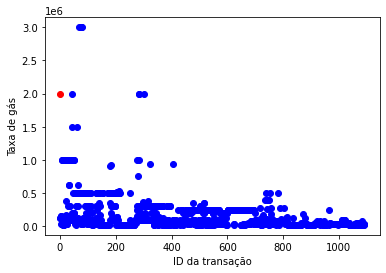

In [19]:
# Plota o gráfico das transações anômalas
plt.scatter(anomalies[0], matrixTransactions[anomalies[0], 1], color='r')
plt.scatter(np.delete(np.arange(len(matrixTransactions)), anomalies[0]), matrixTransactions[np.delete(np.arange(len(matrixTransactions)), anomalies[0]), 1], color='b')
plt.xlabel('ID da transação')
plt.ylabel('Taxa de gás')
plt.show()


Número de transações:  1092
Número de anomalias:  11


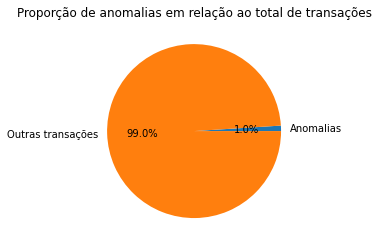

In [20]:
# conta o número de registros em "matrixTransactions" e "anomalies"
numTransactions = len(matrixTransactions)
numAnomalies = len(anomalies)

# mostra o número de registros em "matrixTransactions" e "anomalies"
print('Número de transações: ', numTransactions)
print('Número de anomalias: ', numAnomalies)

# cria o gráfico de pizza
labels = ['Anomalias', 'Outras transações']
sizes = [numAnomalies, numTransactions - numAnomalies]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Proporção de anomalias em relação ao total de transações')
plt.show()

In [21]:
# Cria um array de detecções
import datetime
import json

detections = []
for idx in anomalies:
    tx = jsonData["result"][idx]
    timeStamp = int(jsonData["result"][i]["timeStamp"])
    # Cria um objeto datetime com base no valor de timeStamp
    dateTime = datetime.datetime.fromtimestamp(timeStamp)
    # Formata a data e hora de acordo com o formato desejado (ano-mês-dia hora:minutos:segundos)
    dateTimeStr = dateTime.strftime('%Y/%m/%d %H:%M:%S')
    #Transformando gasPrice em valores ETH
    #valor_eth = float( ( float(tx["gasPrice"]) * float(tx["gas"]) ) / (10^18) )
    gasPrice_wei = int(tx['gasPrice'])
    gas = int(tx['gas'])
    valor_eth = gasPrice_wei * gas / 10**18
    
    #criando a resposta
    detection = {
        "blockNumber": tx["blockNumber"],
        "from": tx["from"],
        "to": tx["to"],
        "gas": tx["gas"],
        "ETH": valor_eth,
        "isError": tx["isError"],
        "contractAddress": tx["contractAddress"],
        "hash": tx["hash"],
        "blockHash": tx["blockHash"],
        "timeStamp": dateTimeStr
    }
    detections.append(detection)

# Imprime a resposta em json contendo as detecções
print(json.dumps(detections, indent=4))

[
    {
        "blockNumber": "54092",
        "from": "0x5abfec25f74cd88437631a7731906932776356f9",
        "to": "",
        "gas": "2000000",
        "ETH": 20.0,
        "isError": "0",
        "contractAddress": "0xde0b295669a9fd93d5f28d9ec85e40f4cb697bae",
        "hash": "0x9c81f44c29ff0226f835cd0a8a2f2a7eca6db52a711f8211b566fd15d3e0e8d4",
        "blockHash": "0xd3cabad6adab0b52eb632c386ea194036805713682c62cb589b5abcd76de2159",
        "timeStamp": "2023/03/27 17:40:35"
    },
    {
        "blockNumber": "95527",
        "from": "0xcda0ad7542e30bf520652a05056ebe0105c7e49a",
        "to": "0xde0b295669a9fd93d5f28d9ec85e40f4cb697bae",
        "gas": "2000000",
        "ETH": 0.11039980673,
        "isError": "0",
        "contractAddress": "",
        "hash": "0x641700539e2d48e8eecd6c11ce8089405f394b920dd2ebefb0fcf5f9c42c7fa5",
        "blockHash": "0x1bed59eb685f990c4ad66c5ed183c91435ad7a1b787f1a331ec64f7969eabdef",
        "timeStamp": "2023/03/27 17:40:35"
    },
    {
     

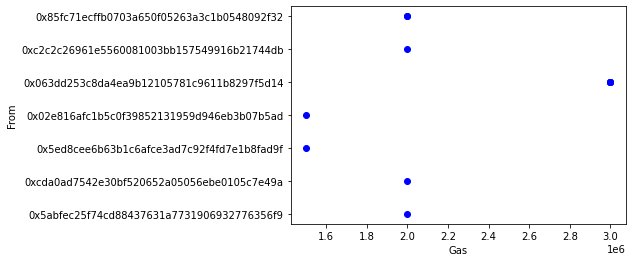

In [22]:
# Plota o gráfico de dispersão
x = [int(tx['gas']) for tx in detections]
y = [tx['from'] for tx in detections]

plt.scatter(x, y, color='b')
plt.xlabel('Gas')
plt.ylabel('From')
plt.show()

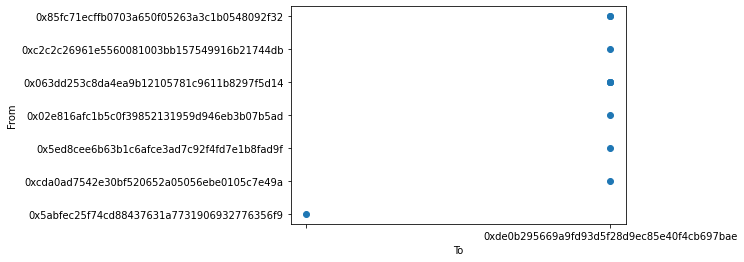

In [23]:
# cria listas com os dados necessários
x = [tx['to'] for tx in detections]
y = [tx['from'] for tx in detections]

gases = [int(tx['gas']) for tx in detections]

# plota o gráfico de dispersão
plt.scatter(x, y)
plt.xlabel('To')
plt.ylabel('From')
plt.show()